Health Insurance Dataset

Task:
- Build a model that predicts "charges" for a given person based on their features.
- Evaluate the quality of your model.
- Identify the factors with the highest impact.

Expected result - link to a GitHub repo with:
- Code for the solution (any programming language, Python or R preferred).
- Brief summary of the solution*: what did you do, which steps did you make, how to interpret the results.

* Both code and solution can be a single report file, e.g. .ipynb or .rmd

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

In [2]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
X = insurance.drop(columns=['charges'])
y = insurance['charges']
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


### Original charges 

(array([536., 398., 129.,  86.,  35.,  59.,  57.,  32.,   2.,   4.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <a list of 10 Patch objects>)

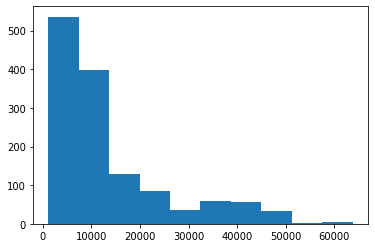

In [4]:
plt.hist(y)

### Log charges

(array([ 46., 105., 101., 155., 198., 283., 156., 123., 115.,  56.]),
 array([ 7.02275569,  7.42678461,  7.83081352,  8.23484244,  8.63887136,
         9.04290027,  9.44692919,  9.8509581 , 10.25498702, 10.65901594,
        11.06304485]),
 <a list of 10 Patch objects>)

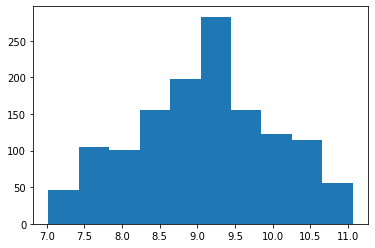

In [5]:
plt.hist(np.log(y))

We will predict log to reduce dispersion of predictions

## Preprocess
- one hot encoding of categorical features sex, children, smoker, region
- making one hot encoding of categories for thresholds age

Normalization of bmi we are going to do after splitting into train and test parts

### Age

(array([137.,  57.,  28.,  56.,  28.,  56.,  28.,  54.,  27.,  52.,  26.,
         50.,  25.,  50.,  27.,  54.,  54.,  29.,  58.,  29.,  57.,  29.,
         57.,  28.,  52.,  26.,  50.,  23.,  46.,  45.]),
 array([18.        , 19.53333333, 21.06666667, 22.6       , 24.13333333,
        25.66666667, 27.2       , 28.73333333, 30.26666667, 31.8       ,
        33.33333333, 34.86666667, 36.4       , 37.93333333, 39.46666667,
        41.        , 42.53333333, 44.06666667, 45.6       , 47.13333333,
        48.66666667, 50.2       , 51.73333333, 53.26666667, 54.8       ,
        56.33333333, 57.86666667, 59.4       , 60.93333333, 62.46666667,
        64.        ]),
 <a list of 30 Patch objects>)

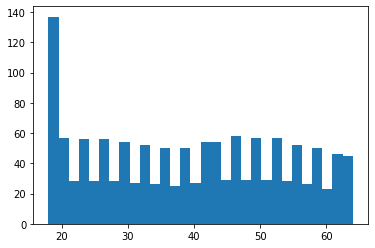

In [6]:
plt.hist(X['age'], bins=30)

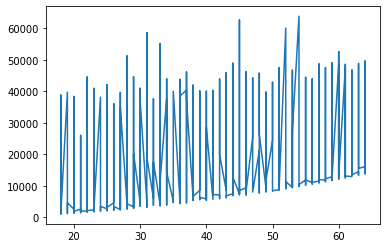

In [7]:
plt.plot(np.sort(X['age']), y[np.argsort(X['age'])])

We splitted column age into 30 bins and, as we see by the distribution on a histogram, after 20 the number of elements can be grouped to have pretty much same number of elements in one group. 
As we see on a plot, that shows how the charge changes as age changes, there is no big preponderance of charge in certain age - so we actually can set thresholds and split age into several groups to build categories.

(array([222., 140., 109., 128., 102., 137., 144., 114., 128., 114.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <a list of 10 Patch objects>)

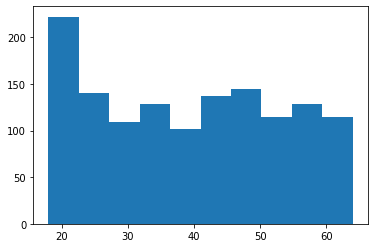

In [8]:
plt.hist(X['age'], bins=10)

As we see how the age distributed, when we split on 10 bins, approximately we can take around 5 years in a group.

In [9]:
X['<20'] = np.float64(X['age'] < 20)
for year in range(20, 61, 5):
    X[f'{year}-{year + 5}'] = np.float64((year < X['age'].values) == (X['age'].values < year + 5))
X.head()

,age,sex,bmi,children,smoker,region,<20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,60-65
0,19,female,27.900,0,yes,southwest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18,male,33.770,1,no,southeast,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,male,33.000,3,no,southeast,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33,male,22.705,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32,male,28.880,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print("length of age categories:\n", 
      {name_col : np.sum(X[name_col]) 
       for name_col in X.columns if '0' in name_col})

length of age categories:
 {'<20': 137.0, '20-25': 112.0, '25-30': 111.0, '30-35': 105.0, '35-40': 100.0, '40-45': 108.0, '45-50': 115.0, '50-55': 114.0, '55-60': 102.0, '60-65': 91.0}


In [11]:
X = X.drop(columns='age')
X.head()

,sex,bmi,children,smoker,region,<20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,60-65
0,female,27.900,0,yes,southwest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,male,33.770,1,no,southeast,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,male,33.000,3,no,southeast,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,male,22.705,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,male,28.880,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sex, children, smoker, region - one hot encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

We are one hot encoding binary features with dropping one value not to have two features with negative correlation (equal to -1)

In [13]:
encoder_bin = OneHotEncoder(sparse=False, drop='first')
encoder_bin.fit(X[['sex', 'smoker']])

encoder_other = OneHotEncoder(sparse=False, drop=None)
encoder_other.fit(X[['children', 'region']])

transformed_bin = encoder_bin.transform(X[['sex', 'smoker']])
transformed_other = encoder_other.transform(X[['children', 'region']])

In [14]:
print(encoder_bin.get_feature_names(['sex', 'smoker']))
print(encoder_other.get_feature_names(['children', 'region']))

['sex_male' 'smoker_yes']
['children_0' 'children_1' 'children_2' 'children_3' 'children_4'
 'children_5' 'region_northeast' 'region_northwest' 'region_southeast'
 'region_southwest']


In [15]:
for i, name in enumerate(encoder_bin.get_feature_names(['sex', 'smoker'])):
    X[name] = transformed_bin[:, i]
    
for i, name in enumerate(encoder_other.get_feature_names(['children', 'region'])):
    X[name] = transformed_other[:, i]
    
X = X.drop(columns=['sex', 'children', 'smoker', 'region'])
X.head()

,bmi,<20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
0,27.900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,33.770,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,33.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22.705,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.880,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
print("number of 1s in categories:\n", 
      {name_col : np.sum(X[name_col]) 
       for name_col in X.columns if name_col != 'bmi'})

number of 1s in categories:
 {'<20': 137.0, '20-25': 112.0, '25-30': 111.0, '30-35': 105.0, '35-40': 100.0, '40-45': 108.0, '45-50': 115.0, '50-55': 114.0, '55-60': 102.0, '60-65': 91.0, 'sex_male': 676.0, 'smoker_yes': 274.0, 'children_0': 574.0, 'children_1': 324.0, 'children_2': 240.0, 'children_3': 157.0, 'children_4': 25.0, 'children_5': 18.0, 'region_northeast': 324.0, 'region_northwest': 325.0, 'region_southeast': 364.0, 'region_southwest': 325.0}


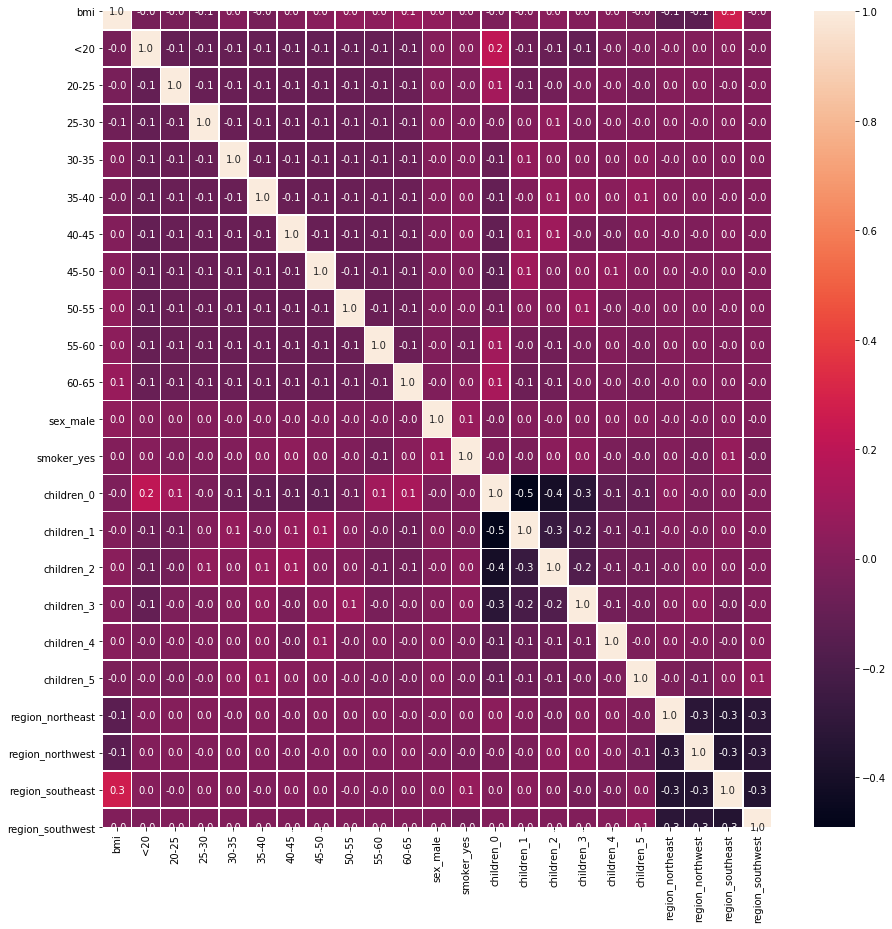

In [17]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Okay, so we don't have correlated features now

## Split 

In [21]:
from sklearn.model_selection import train_test_split

y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, shuffle=True)

print("length of train:", len(y_train), 
      "length of test:", len(y_test), 
      "length of val:", len(y_val))

length of train: 1003 length of test: 201 length of val: 134


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train.loc[:, 'bmi'] = scaler.fit_transform(X_train['bmi'][:, np.newaxis])
X_test.loc[:, 'bmi'] = scaler.transform(X_test['bmi'][:, np.newaxis])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [23]:
X_train.head()

,bmi,<20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
649,0.371686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
743,-0.665075,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
948,0.092275,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
138,0.197667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
894,0.231980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
X_test.head()

,bmi,<20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
258,-1.025368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
375,-0.388932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
464,-0.901185,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
91,-0.963277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
878,-0.308867,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Making predictions

### Let's start with basic linear regression and see where it goes

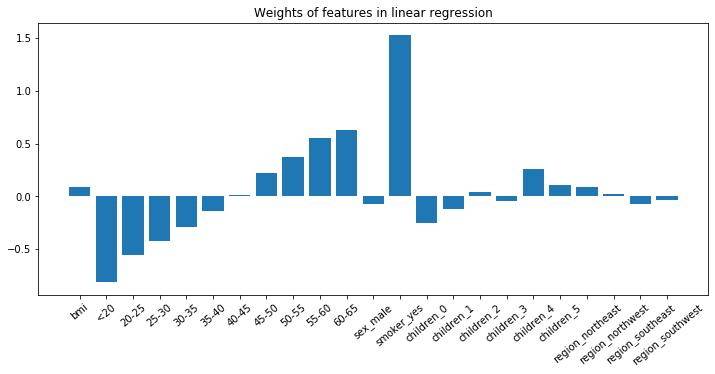

In [25]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)


plt.figure(figsize=(12, 5))

coef = linear_regression.coef_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Weights of features in linear regression')
plt.show()

In [26]:
lin_regr_feature_importance = X.columns[np.argsort(np.abs(linear_regression.coef_))[::-1]]

Evaluation 

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def errors_of_prediction(model, X_test, y_test=y_test):
    y_test_predicted = model.predict(X_test)
    print('MSE:', mean_squared_error(np.exp(y_test), np.exp(y_test_predicted)))
    print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_predicted))))
    print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(y_test_predicted)))

    print('mean absolute relative_error:', 
          1 / len(y_test) * np.sum(np.abs(np.exp(y_test_predicted) / np.exp(y_test) - 1) * 100), '%')

In [28]:
errors_of_prediction(linear_regression, X_test)

MSE: 51222044.77954889
RMSE: 7156.9577880234065
MAE: 3899.700706438219
mean absolute relative_error: 34.31970574518475 %


As we see by weights, not all the features appear to be valuable in the linear regression model, let's try to improve the result by selecting most important ones.

#### Feature selection

In [29]:
from sklearn.feature_selection import RFECV

def feature_selection_estimation(model):
    rfecv = RFECV(estimator=model, step=1, cv=5)
    selector = rfecv.fit(X_train, y_train)
    
    scores = selector.grid_scores_
    plt.plot(range(len(scores)), scores)
    plt.xlabel('Количество')
    plt.ylabel('Качество на кросс-валидации')
    plt.show()
    
    print('filtered columns:', X.columns[rfecv.support_])
    print('deleted:', [col for col in X.columns if col not in X.columns[rfecv.support_]])
    
    X_train_filtered = selector.transform(X_train)
    X_test_filtered = selector.transform(X_test)


    model.fit(X_train_filtered, y_train)
    errors_of_prediction(model, X_test_filtered)

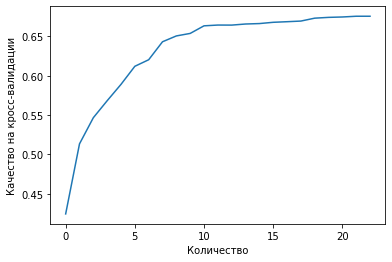

filtered columns: Index(['bmi', '<20', '20-25', '25-30', '30-35', '35-40', '45-50', '50-55',
       '55-60', '60-65', 'sex_male', 'smoker_yes', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')
deleted: ['40-45']
MSE: 51365347.010164425
RMSE: 7166.962188414588
MAE: 3904.9406525555646
mean absolute relative_error: 34.37262572099544 %


In [30]:
feature_selection_estimation(linear_regression)

Seems like for linear regression all the features are important as a result was slightly better for all the features

### Regression with random forest

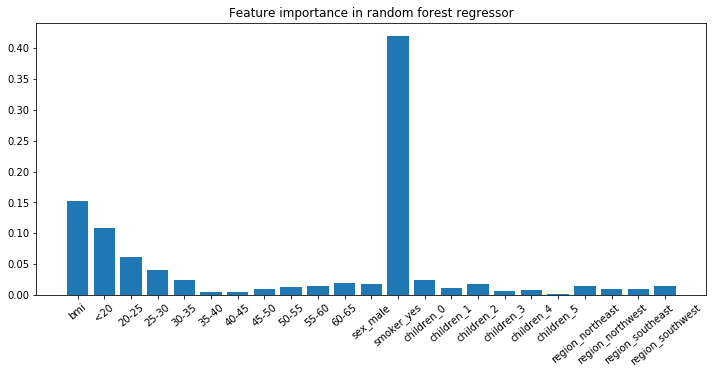

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(criterion='mse', n_estimators=15)
rf.fit(X_train, y_train)

plt.figure(figsize=(12, 5))

coef = rf.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in random forest regressor')
plt.show()

In [32]:
errors_of_prediction(rf, X_test)

MSE: 17327647.296809856
RMSE: 4162.649072022509
MAE: 2458.6550720335654
mean absolute relative_error: 33.88178422358321 %


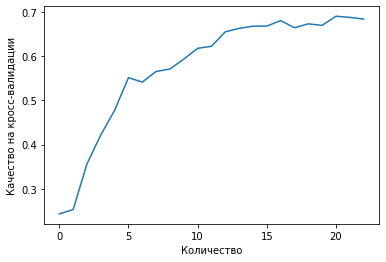

filtered columns: Index(['bmi', '<20', '20-25', '25-30', '30-35', '35-40', '45-50', '50-55',
       '55-60', '60-65', 'sex_male', 'smoker_yes', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')
deleted: ['40-45', 'children_5']
MSE: 18610091.19392755
RMSE: 4313.941491713529
MAE: 2482.5387863115975
mean absolute relative_error: 32.13767566675603 %


In [33]:
feature_selection_estimation(rf)

Grid search best hyperparams for random forest

In [34]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [102]:
def search_best_hyperparams(estimator, params, X_train=X_train):
    searcher = RandomizedSearchCV(estimator=estimator, param_distributions=params, cv=5, n_iter=30)
    searcher.fit(X_train, y_train)
    
    return searcher.best_estimator_, searcher.best_params_

In [36]:
best_estimator, best_params = search_best_hyperparams(RandomForestRegressor(criterion='mse'), 
                                                      params={'n_estimators': range(10, 300, 10),
                                                              'max_depth': range(10, 100, 10),
                                                              'max_leaf_nodes': range(10, 100, 5)})

print(best_estimator)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=15,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [37]:
print('best params for random forest:', best_params)

best params for random forest: {'n_estimators': 150, 'max_leaf_nodes': 15, 'max_depth': 20}


In [38]:
errors_of_prediction(best_estimator, X_test)

MSE: 14284533.424722401
RMSE: 3779.488513638109
MAE: 2183.1880480555847
mean absolute relative_error: 25.6103157792263 %


In [39]:
rf_regr_feature_importance = X.columns[np.argsort(best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance)), columns=["lin regr",
                                                                     "rf regr"])

,lin regr,rf regr
0,smoker_yes,smoker_yes
1,<20,<20
2,60-65,20-25
3,20-25,bmi
4,55-60,25-30
5,25-30,60-65
6,50-55,30-35
7,30-35,55-60
8,children_4,50-55
9,children_0,children_2


### Stochastic Gradient Regressor

In [40]:
from sklearn.linear_model import SGDRegressor

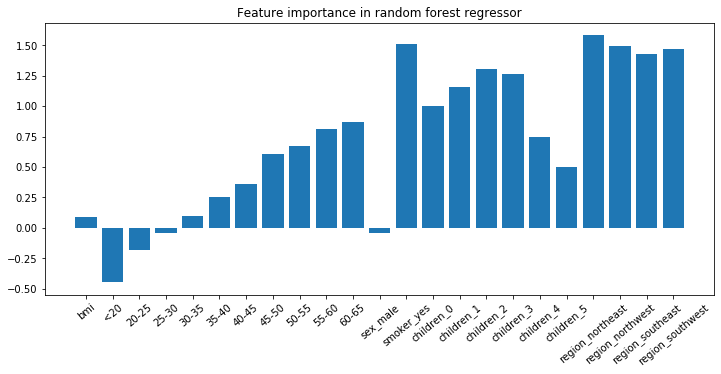

In [41]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
coef = sgd.coef_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in random forest regressor')
plt.show()

In [42]:
errors_of_prediction(sgd, X_test)

MSE: 51842027.34708754
RMSE: 7200.140786615741
MAE: 4061.978039102254
mean absolute relative_error: 37.19487826443004 %


In [43]:
best_estimator, best_params = search_best_hyperparams(SGDRegressor(), 
                                                      params={'penalty': ['l2', 'l1', 'elasticnet'],
                                                              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
                                                              'l1_ratio': np.arange(0, 1.1, 0.1),
                                                              'tol': [0.01, 0.001, 0.0001],
                                                              'learning_rate': ['constant',
                                                                                'optimal',
                                                                                'invscaling',
                                                                                'adaptive'],
                                                              'eta0': [0.0001, 0.001, 0.01, 0.1],
                                                              'power_t': [0.1, 0.25, 0.5, 0.7],
                                                              'early_stopping': [True]})

print('best model:', best_estimator)
print('best params for SGD:', best_params)
print('Results of evaluating the best SGD')
errors_of_prediction(best_estimator, X_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_mo

best model: SGDRegressor(alpha=1e-05, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.1,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
best params for SGD: {'tol': 0.0001, 'power_t': 0.25, 'penalty': 'l2', 'learning_rate': 'invscaling', 'l1_ratio': 0.1, 'eta0': 0.1, 'early_stopping': True, 'alpha': 1e-05}
Results of evaluating the best SGD
MSE: 82365801.72720668
RMSE: 9075.560683903044
MAE: 4741.300464658936
mean absolute relative_error: 42.72202972665715 %


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
sgd_regr_feature_importance = X.columns[np.argsort(best_estimator.coef_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr"])

,lin regr,rf regr,sgd regr
0,smoker_yes,smoker_yes,region_northwest
1,<20,<20,region_northeast
2,60-65,20-25,smoker_yes
3,20-25,bmi,region_southwest
4,55-60,25-30,region_southeast
5,25-30,60-65,children_4
6,50-55,30-35,children_2
7,30-35,55-60,children_3
8,children_4,50-55,children_5
9,children_0,children_2,children_1


Surprisingly the method of stochastic gradient descent gives high importance to the categories showing regions and number of children. It would've been interesting to mix different models so they all give some impact to the result based on different features.

### Let's also try out XGBoost and Catboost on this dataset

* https://github.com/dmlc/xgboost
* https://github.com/catboost/catboost

In [45]:
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from catboost import CatBoostRegressor, Pool

In [113]:
X_train_xgb = X_train.copy()
X_train_xgb.columns = [col.replace("<", "_") for col in X_train_xgb.columns]
X_test_xgb = X_test.copy()
X_test_xgb.columns = X_train_xgb.columns
X_val_xgb = X_val.copy()
X_val_xgb.columns = X_train_xgb.columns

#### XGBoost

In [123]:
best_estimator, best_params = search_best_hyperparams(XGBRegressor(objective ='reg:squarederror', 
                                                                   booster='gbtree',
                                                                   eval_metric="rmse"), 
                                                      params={'n_estimators': range(10, 300, 10),
                                                              'max_depth': range(10, 100, 10)},
                                                      X_train=X_train_xgb)

In [124]:
print('best model:', best_estimator)
print('best params for XGBoost:', best_params)
print('Results of evaluating the best XGBoost')
errors_of_prediction(best_estimator, X_test_xgb)

best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=50, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
best params for XGBoost: {'n_estimators': 20, 'max_depth': 50}
Results of evaluating the best XGBoost
MSE: 21071535.90661948
RMSE: 4590.374266508068
MAE: 2791.0832359380834
mean absolute relative_error: 35.31067092483248 %


In [ ]:
plt.figure(figsize=(12, 5))
coef = best_estimator.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in XGBoost')
plt.show()

In [114]:
xgb_regr_feature_importance = X.columns[np.argsort(best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance,
                              xgb_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr",
                                                                      "xgboost"])

,lin regr,rf regr,sgd regr,xgboost
0,smoker_yes,smoker_yes,region_northwest,smoker_yes
1,<20,<20,region_northeast,<20
2,60-65,20-25,smoker_yes,60-65
3,20-25,bmi,region_southwest,55-60
4,55-60,25-30,region_southeast,children_0
5,25-30,60-65,children_4,20-25
6,50-55,30-35,children_2,30-35
7,30-35,55-60,children_3,50-55
8,children_4,50-55,children_5,children_4
9,children_0,children_2,children_1,25-30


#### CatBoost

In [131]:
best_estimator, best_params = search_best_hyperparams(CatBoostRegressor(loss_function='RMSE', 
                                                                        silent=True, iterations=100), 
                                                      params={'depth': range(5, 12),
                                                              'l2_leaf_reg': [0.1, 0.3, 0.7],
                                                              'bagging_temperature': [0., 0.5, 1, 2, 10]},
                                                      X_train=X_train)

In [132]:
print('best model:', best_estimator)
print('best params for CatBoost:', best_params)

# cat = CatBoostRegressor(loss_function='RMSE', silent=True, iterations=100)
print('Results of evaluating the best CatBoost')
errors_of_prediction(best_estimator, X_test)

best model: <catboost.core.CatBoostRegressor object at 0x13e4e3350>
best params for CatBoost: {'l2_leaf_reg': 0.3, 'depth': 9, 'bagging_temperature': 10}
Results of evaluating the best CatBoost
MSE: 22152381.531885564
RMSE: 4706.631654579054
MAE: 2714.902854779179
mean absolute relative_error: 31.22132290394371 %


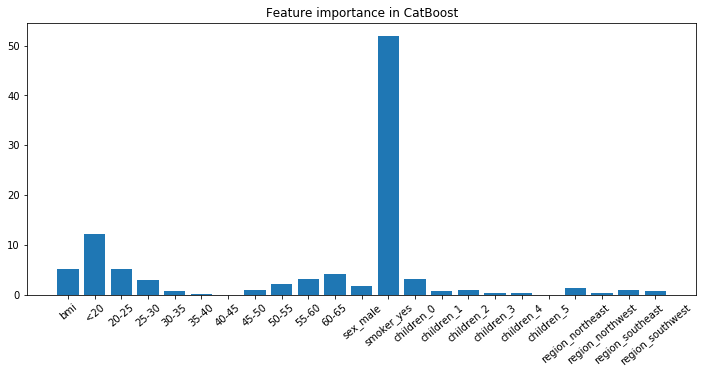

In [133]:
plt.figure(figsize=(12, 5))
coef = best_estimator.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in CatBoost')
plt.show()

In [134]:
cat_regr_feature_importance = X.columns[np.argsort(best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance,
                              xgb_regr_feature_importance,
                              cat_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr",
                                                                      "xgboost",
                                                                      "catboost"])

,lin regr,rf regr,sgd regr,xgboost,catboost
0,smoker_yes,smoker_yes,region_northwest,smoker_yes,smoker_yes
1,<20,<20,region_northeast,<20,<20
2,60-65,20-25,smoker_yes,60-65,20-25
3,20-25,bmi,region_southwest,55-60,bmi
4,55-60,25-30,region_southeast,children_0,60-65
5,25-30,60-65,children_4,20-25,children_0
6,50-55,30-35,children_2,30-35,55-60
7,30-35,55-60,children_3,50-55,25-30
8,children_4,50-55,children_5,children_4,50-55
9,children_0,children_2,children_1,25-30,sex_male


In [42]:
import scipy
scipy.test()

============================================================================================================ test session starts =============================================================================================================
platform darwin -- Python 3.7.6, pytest-5.2.2, py-1.8.0, pluggy-0.13.0
rootdir: /Users/alinakarpovich/Evolution Gaming/ds_internship_task
collected 26406 items / 10731 deselected / 15675 selected

_build_utils/tests/test_circular_imports.py .                                                                                                                                                                                          [  0%]
_build_utils/tests/test_scipy_version.py .                                                                                                                                                                                             [  0%]
_lib/tests/test__gcutils.py ......                                                      

False